In [1]:
import json
from apache_beam.transforms.trigger import AfterProcessingTime, AccumulationMode
import apache_beam as beam
from apache_beam.runners.interactive import interactive_runner
import apache_beam.runners.interactive.interactive_beam as ib
from apache_beam.transforms import trigger
from apache_beam.options import pipeline_options
from apache_beam.options.pipeline_options import GoogleCloudOptions
from apache_beam.io.gcp.bigtableio import WriteToBigTable
from apache_beam.io.textio import WriteToText
import google.auth
import datetime

subscription = "projects/forrest-test-project-333203/subscriptions/assetSnapshotService"
project_id = "forrest-test-project-333203"
instance_id = "my-bigtable"
table_id = "user_asset_snapshot"
dataflow_gcs_location = 'gs://forrest-bigdata-bucket/dataflow'

# big table
table_spec = f"{project_id}:realtime.user_asset_snapshot"
table_schema = "row_key:STRING, elem0:STRING, elem1:STRING, elem10:STRING, elem11:STRING"

In [2]:
# Setting up the Beam pipeline options.
options = pipeline_options.PipelineOptions()

# Sets the pipeline mode to streaming, so we can stream the data from PubSub.
options.view_as(pipeline_options.StandardOptions).streaming = True

# Sets the project to the default project in your current Google Cloud environment.
# The project will be used for creating a subscription to the PubSub topic.
_, options.view_as(GoogleCloudOptions).project = google.auth.default()

In [ ]:
ib.options.recording_duration = '2m'

## write to bigtable

In [3]:
# class for buiding bigtable row
class CreateRowFn(beam.DoFn):
    def process(
        self,
        elem,
        timestamp=beam.DoFn.TimestampParam,
        window=beam.DoFn.WindowParam):
        
        from google.cloud.bigtable import row
        import datetime


        MAX_TS = 2147483647
        ts_window = MAX_TS - int(window.end)
        row_key = f"{elem[0]}|{ts_window:010d}"
        direct_row = row.DirectRow(row_key=row_key)
        ts_modified_at = elem[1][1] / 1000 / 1000
        
        # set balance
        direct_row.set_cell(
            'cf1',
            'balance',
            elem[1][0],
            timestamp=datetime.datetime.utcfromtimestamp(ts_modified_at))
        
        direct_row.set_cell(
            'cf1',
            'modified_at',
            str(elem[1][1]),
            timestamp=datetime.datetime.utcfromtimestamp(ts_modified_at)) 
        
        yield direct_row

In [4]:
class TestFn(beam.DoFn):
    def process(
        self,
        elem,
        timestamp=beam.DoFn.TimestampParam,
        window=beam.DoFn.WindowParam):
        
        from google.cloud.bigtable import row
        import datetime


        MAX_TS = 2147483647
        ts_window = MAX_TS - int(window.end)
        row_key = f"{elem[0]}|{ts_window:010d}"
        # row_key = str(window.end)
        direct_row = row.DirectRow(row_key=row_key)
        # ts_modified_at = elem[1][1] / 1000 / 1000
        
        # set balance
        direct_row.set_cell(
            'cf1',
            'balance',
            '0.0',
            timestamp=datetime.datetime.utcfromtimestamp(window.end))
        
        direct_row.set_cell(
            'cf1',
            'modified_at',
            '123456',
            timestamp=datetime.datetime.utcfromtimestamp(window.end)) 
        
        yield direct_row

In [5]:
class CreateBqRowFn(beam.DoFn):
    def process(
        self,
        elem,
        timestamp=beam.DoFn.TimestampParam,
        window=beam.DoFn.WindowParam):
        
        # from google.cloud.bigtable import row
        # import datetime


        MAX_TS = 2147483647
        ts_window = MAX_TS - int(window.end)
        row_key = f"{elem[0]}|{ts_window:010d}"
        # row_key = str(window.end)
        # direct_row = row.DirectRow(row_key=row_key)
        # ts_modified_at = elem[1][1] / 1000 / 1000
        
        # set balance
#         direct_row.set_cell(
#             'cf1',
#             'balance',
#             '0.0',
#             timestamp=datetime.datetime.utcfromtimestamp(window.end))
        
#         direct_row.set_cell(
#             'cf1',
#             'modified_at',
#             '123456',
#             timestamp=datetime.datetime.utcfromtimestamp(window.end)) 
        
        data = {
            "row_key": row_key,
            "elem0": str(elem[0]),
            "elem1": str(elem[1]),
            "elem10": str("elem10"),
            "elem11": str("elem11")
            # "elem10": str(elem[1][0]),
            # "elem11": str(elem[1][1])
        }
        
        yield data

In [6]:
def upsert_event(elem):
    return elem.get("op", "DoesNotExist") in ["c", "u", "r"] and elem["source"]["db"] == "asset" and elem["source"]["table"] == "user_asset"

In [7]:
def with_timestamp(elem):
    from apache_beam.transforms.window import TimestampedValue
    
    ts = int(elem["source"]["ts_ms"] / 1000)
    key = f'{elem["after"]["user_id"]:012d}|{elem["after"]["token"]}'
    value = (elem["after"]["balance"], elem['after']['modified_at'], ts)

    pair = (key, value)
    
    return TimestampedValue(pair, ts)   

In [8]:
# p = beam.Pipeline(interactive_runner.InteractiveRunner(), options=options)
p = beam.Pipeline(options=options)
latest_elements_per_key = (
    p
    | "read from pubsub" >> beam.io.ReadFromPubSub(subscription=subscription)
    | 'transform to json' >> beam.Map(json.loads)
    | 'filter cdc event' >> beam.Filter(upsert_event)
    | 'with timestamps' >> beam.Map(with_timestamp)
    | 'window' >> beam.WindowInto(
        beam.window.FixedWindows(60),
        trigger=trigger.AfterWatermark(
            # early=trigger.AfterProcessingTime(delay=1 * 10), 
            late=trigger.AfterCount(1)),
        # timestamp_combiner=beam.window.TimestampCombiner.OUTPUT_AT_LATEST,
        allowed_lateness=1800,
        accumulation_mode=AccumulationMode.DISCARDING)
    | 'Get latest elements per key' >> beam.combiners.Latest.PerKey()
    | 'Filter out empty element' >> beam.Filter(lambda elem: elem and elem[0] and elem[1])
    # | 'Build bigquery row' >> beam.ParDo(CreateBqRowFn())
    # | 'Write to bigquery' >> beam.io.WriteToBigQuery(
    #     table_spec,
    #     schema=table_schema,
    #     create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED)
    # | 'Write to gs' >> WriteToText(dataflow_gcs_location + "/beam-data")
    | 'Build bigtable row' >> beam.ParDo(CreateRowFn())
    | 'Write to bigtable' >> WriteToBigTable(
        project_id=project_id,
        instance_id=instance_id,
        table_id=table_id)
)

In [ ]:
ib.show(latest_elements_per_key, include_window_info=True)

In [ ]:
ib.collect(latest_elements_per_key, include_window_info=True, duration=120)

# submit dataflow runner

In [9]:
from apache_beam.runners import DataflowRunner


# Set the Google Cloud region to run Dataflow.
options.view_as(GoogleCloudOptions).region = 'us-central1'


# Set the staging location. This location is used to stage the
# Dataflow pipeline and SDK binary.
options.view_as(GoogleCloudOptions).staging_location = '%s/staging' % dataflow_gcs_location

# Set the temporary location. This location is used to store temporary files
# or intermediate results before outputting to the sink.
options.view_as(GoogleCloudOptions).temp_location = '%s/temp' % dataflow_gcs_location

# Set the SDK location. This is used by Dataflow to locate the
# SDK needed to run the pipeline.
# options.view_as(pipeline_options.SetupOptions).sdk_location = (
#     '/root/apache-beam-custom/packages/beam/sdks/python/dist/apache-beam-%s0.tar.gz' %
#     beam.version.__version__)

options.view_as(GoogleCloudOptions).job_name = f"user-asset-snapshot-job-{int(datetime.datetime.utcnow().timestamp())}"
options.view_as(GoogleCloudOptions).service_account_email = "notebook@forrest-test-project-333203.iam.gserviceaccount.com"
options.view_as(GoogleCloudOptions).enable_streaming_engine = True
options.view_as(GoogleCloudOptions).update = False
options.view_as(pipeline_options.WorkerOptions).network = "bigdata-network"
options.view_as(pipeline_options.WorkerOptions).subnetwork = "regions/us-central1/subnetworks/dataflow-network"
options.view_as(pipeline_options.WorkerOptions).use_public_ips = False
options.view_as(pipeline_options.SetupOptions).save_main_session = False

In [10]:
runner = DataflowRunner()
runner.run_pipeline(p, options=options)

<DataflowPipelineResult <Job
 createTime: '2021-12-20T05:49:33.956026Z'
 currentStateTime: '1970-01-01T00:00:00Z'
 id: '2021-12-19_21_49_33-16093715343671654802'
 location: 'us-central1'
 name: 'user-asset-snapshot-job-1639979357'
 projectId: 'forrest-test-project-333203'
 stageStates: []
 startTime: '2021-12-20T05:49:33.956026Z'
 steps: []
 tempFiles: []
 type: TypeValueValuesEnum(JOB_TYPE_STREAMING, 2)> at 0x7f0fb00baa90>

# Functions for retrieving data from hbase

In [134]:
# supported interval: 1m, 5m, 15m, 30m, 1h, 4h, 1d
# max time range is 30 days

from google.cloud import bigtable
from google.cloud.bigtable import column_family
from google.cloud.bigtable import row_filters
from google.cloud.bigtable import row

client = bigtable.Client(project=project_id)
instance = client.instance(instance_id)
table = instance.table(table_id)
base_datapoints = 60
MAX_TS = 2147483647
MIN_TS = 1483200000

granularity_meta = {
    "1m": {"seconds": 60 * 1, "num_datapoints": 1 * base_datapoints},
    "5m": {"seconds": 60 * 5, "num_datapoints": 5 * base_datapoints},
    "15m": {"seconds": 60 * 15, "num_datapoints": 15 * base_datapoints},
    "30m": {"seconds": 60 * 30, "num_datapoints": 30 * base_datapoints},
    "1h": {"seconds": 60 * 60, "num_datapoints": 60 * base_datapoints},
    "4h": {"seconds": 60 * 60 * 4, "num_datapoints": 60 * 4 * base_datapoints},
    "1d": {"seconds": 60 * 60 * 24, "num_datapoints": 60 * 24 * 30}
}

def get_user_asset_snapshots(user_id, token, start, end, granularity='1m'):
    # check start and end
    if start > end:
        raise Exception("Error: Start time later than end time")
        
    if not ((MIN_TS <= start <= MAX_TS) and (MIN_TS <= end <= MAX_TS)):
        raise Exception("Error: Start or end time out of range")
    
    # set start to max_range to avoid too much data being sent
    start = end - granularity_meta[granularity]["seconds"] * granularity_meta[granularity]["num_datapoints"]
    
    
    start_key = f"{user_id:012d}|{token}|{(MAX_TS - end):010d}".encode()
    end_key = f"{user_id:012d}|{token}|{(MAX_TS - start):010d}".encode()
    col_filter = row_filters.ColumnQualifierRegexFilter(b'balance')
    
    rows = table.read_rows(start_key=start_key, end_key=end_key,filter_=col_filter, end_inclusive=True)
    
    results = []
    for row in rows:
        # print(row.row_key.decode())
        ts = MAX_TS - int(row.row_key.decode().split("|")[2])
        balance = row.cells['cf1'][b'balance'][0].value.decode()
        
        results.append((ts, balance))
    
    return results
            
def print_row(row):
    print("Reading data for {}:".format(row.row_key.decode('utf-8')))
    for cf, cols in sorted(row.cells.items()):
        print("Column Family {}".format(cf))
        for col, cells in sorted(cols.items()):
            for cell in cells:
                labels = " [{}]".format(",".join(cell.labels)) \
                    if len(cell.labels) else ""
                print(
                    "\t{}: {} @{}{}".format(col.decode('utf-8'),
                                            cell.value.decode('utf-8'),
                                            cell.timestamp, labels))
    print("")   

In [ ]:
# plot time series
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline


def transform_result(input, granularity):
    x = np.array([datetime.datetime.utcfromtimestamp(item[0]) for item in r])
    # x = np.array([datetime.datetime.utcfromtimestamp(item[0]).strftime('%Y-%m-%d %H:%M:%S') for item in r])
    y = np.array([float(item[1]) for item in r])

    df = pd.DataFrame(data = {'time': x, 'balance': y})
    df["time"] = pd.to_datetime(df["time"])
    df.sort_values(by=["time"], inplace=True)
    df = df.set_index("time").asfreq("1Min")
    df.fillna(method='ffill', inplace=True)
    
    # Filter timestamp according to granularity
    if granularity != "1m":
        interval = granularity_meta[granularity]["seconds"]
        start = df.index[0].round(freq=f"{interval}S")
        
        ts_list = [start, ]
        ts = start
        for i in range(base_datapoints - 1):
            ts += pd.Timedelta(seconds=interval)
            ts_list.append(ts)
        
        df = df[df.index.isin(ts_list)]

    # df.reset_index(level=0, inplace=True)
    # df["time"] = df["time"].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    return df.head(60)

In [ ]:
now = int(datetime.datetime.utcnow().timestamp())
r = get_user_asset_snapshots(213, "CRV", now - 60*60*24*7, now, granularity='5m')
print(len(r))

In [144]:
%timeit -n10 get_user_asset_snapshots(213, "CRV", now - 60*60*24*7, now, granularity='1m')

8.44 ms ± 810 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%pip install seaborn

In [150]:
df =transform_result(r, '5m')
pd.set_option('display.max_rows', None)
print(df.dtypes)
print(df)

balance    float64
dtype: object
                       balance
time                          
2021-12-10 06:00:00  44.116248
2021-12-10 06:05:00  15.523691
2021-12-10 06:10:00  47.429300
2021-12-10 06:15:00  97.814643
2021-12-10 06:20:00  68.468695
2021-12-10 06:25:00  68.468695
2021-12-10 06:30:00  69.595667
2021-12-10 06:35:00  99.611821
2021-12-10 06:40:00  91.998367
2021-12-10 06:45:00  16.277275
2021-12-10 06:50:00  18.240717
2021-12-10 06:55:00  12.762508
2021-12-10 07:00:00  99.217659
2021-12-10 07:05:00  94.530169


<AxesSubplot:xlabel='time', ylabel='balance'>

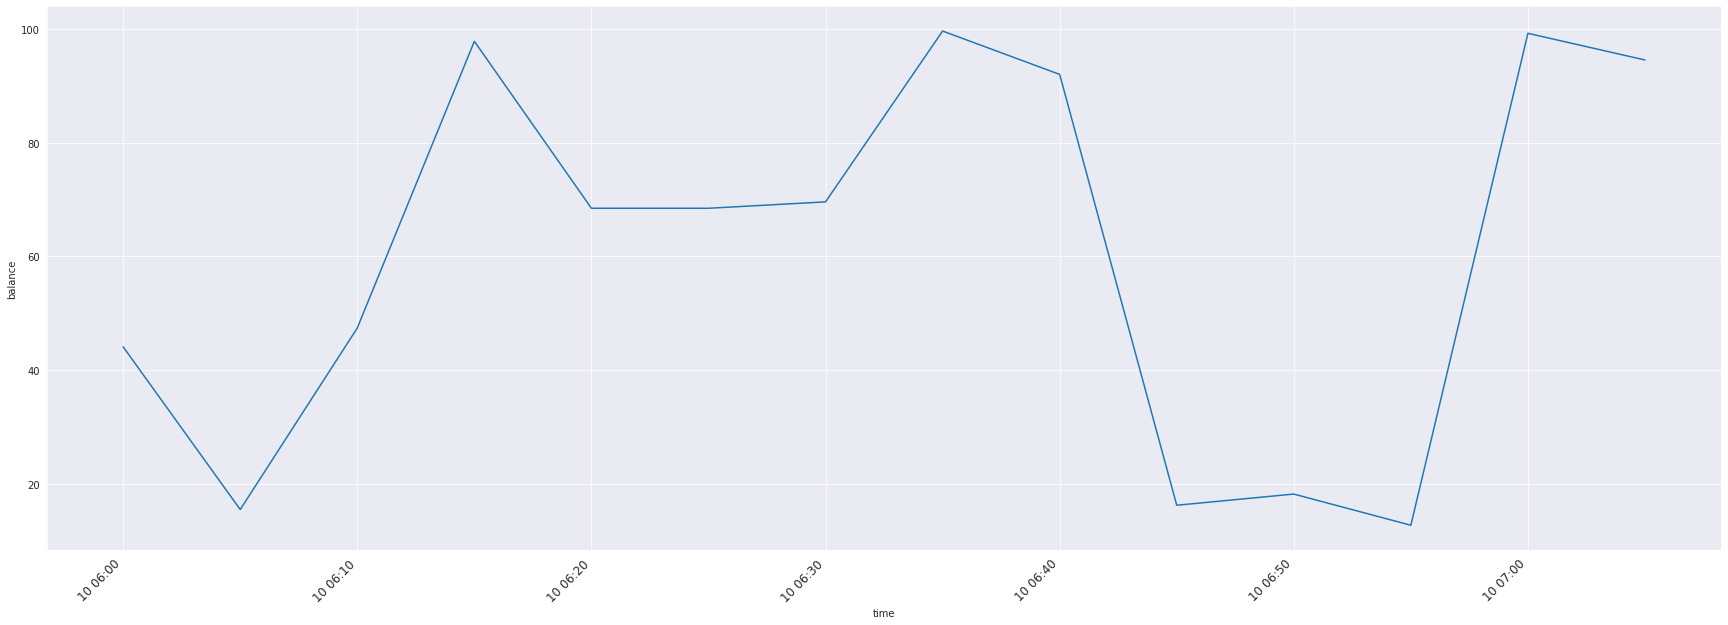

In [151]:
# draw figure
clear_output(wait=True)
plt.figure(figsize=(30,10))
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='large'  
)
sns.set_style("darkgrid")
sns.lineplot(x='time', y='balance', data=df)

In [ ]:
# print(df.index[0].round(freq="86400S"))
# print(df.loc['2021-12-08 15:00:00'])
# print(df[df.index.isin(['2021-12-08 15:00:00',])])
print(datetime.datetime.utcnow().timestamp())

000000000213|CRV|0508645617                                              column=cf1:balance, timestamp=1638838021000, value=4.39835667                                                                                                                                                            
 000000000213|CRV|0508660447                                              column=cf1:balance, timestamp=1638823191000, value=72.77241980                                                                                                                                                           
 000000000213|CRV|0508661747                                              column=cf1:balance, timestamp=1638821893000, value=33.87665605                                                                                                                                                           
 000000000213|CRV|0508663567                                              column=cf1:balance, timestamp=1638820073000, value=82.98481280   

In [ ]:
MAX_TS - 508663567 



# tests

In [ ]:
import apache_beam as beam
import time

def to_unix_time(time_str, format='%Y-%m-%d %H:%M:%S'):
  return time.mktime(time.strptime(time_str, format))

with beam.Pipeline() as pipeline:
  latest_elements_per_key = (
      pipeline
      | 'Create crops' >> beam.Create([
          ('spring', {
              'item': '🥕', 'harvest': '2020-06-28 00:00:00'
          }),
          ('spring', {
              'item': '🍓', 'harvest': '2020-06-16 00:00:00'
          }),
          ('summer', {
              'item': '🥕', 'harvest': '2020-07-17 00:00:00'
          }),
          ('summer', {
              'item': '🍓', 'harvest': '2020-08-26 00:00:00'
          }),
          ('summer', {
              'item': '🍆', 'harvest': '2020-09-04 00:00:00'
          }),
          ('summer', {
              'item': '🥬', 'harvest': '2020-09-18 00:00:00'
          }),
          ('summer', {
              'item': '🍅', 'harvest': '2020-09-22 00:00:00'
          }),
          ('autumn', {
              'item': '🍅', 'harvest': '2020-10-01 00:00:00'
          }),
          ('autumn', {
              'item': '🥬', 'harvest': '2020-10-20 00:00:00'
          }),
          ('autumn', {
              'item': '🍆', 'harvest': '2020-10-26 00:00:00'
          }),
          ('winter', {
              'item': '🥬', 'harvest': '2020-02-24 00:00:00'
          }),
      ])
      | 'With timestamps' >> beam.Map(
          lambda pair: beam.window.TimestampedValue(
              (pair[0], pair[1]['item']), to_unix_time(pair[1]['harvest'])))
      | 'Get latest elements per key' >> beam.combiners.Latest.PerKey()
      | beam.Map(print))

In [ ]:
p = beam.Pipeline(interactive_runner.InteractiveRunner(), options=options)
latest_elements_per_key = (
    p
    # | 'read from string' >> beam.Create(row_str)
    | "read from pubsub" >> beam.io.ReadFromPubSub(subscription=subscription)
    | 'transform to json' >> beam.Map(json.loads)
    | 'with timestamps' >> beam.Map(lambda pair: beam.window.TimestampedValue(
        (f'{pair["after"]["user_id"]:012d}_{pair["after"]["token"]}', (pair["after"]["balance"], pair['after']['modified_at'])), int(pair['source']['ts_ms'] / 1000)))
    | 'window' >> beam.WindowInto(
        beam.window.FixedWindows(10),
        trigger=trigger.AfterWatermark(early=trigger.AfterProcessingTime(delay=1 * 10), late=trigger.AfterCount(1)),
        allowed_lateness=1800,
        accumulation_mode=AccumulationMode.DISCARDING)
    | 'Get latest elements per key' >> beam.combiners.Latest.PerKey()
    # | 'Analyze element' >> beam.ParDo(AnalyzeElement())
    # | beam.Map(print)
)

In [ ]:
row_str=["""{"before":{"id":1,"user_id":1,"token":"BTC","balance":"20.80000000","created_at":1638167717068549,"modified_at":1638359012470943},"after":{"id":1,"user_id":1,"token":"BTC","balance":"20.88000000","created_at":1638167717068549,"modified_at":1638370778828228},"source":{"version":"1.7.1.Final","connector":"mysql","name":"asset","ts_ms":1638370778000,"snapshot":"false","db":"asset","sequence":null,"table":"user_asset","server_id":3915504808,"gtid":"be7fd595-50c2-11ec-bca5-4201c0a80402:43263","file":"mysql-bin.000001","pos":19381107,"row":0,"thread":null,"query":null},"op":"u","ts_ms":1638370778836,"transaction":null}"""]

In [ ]:
row_str.append("""{"before":{"id":1,"user_id":1,"token":"BTC","balance":"20.80000000","created_at":1638167717068549,"modified_at":1638359012470943},"after":{"id":1,"user_id":1,"token":"BTC","balance":"26.88000000","created_at":1638167717068549,"modified_at":1638370778828228},"source":{"version":"1.7.1.Final","connector":"mysql","name":"asset","ts_ms":1638370788000,"snapshot":"false","db":"asset","sequence":null,"table":"user_asset","server_id":3915504808,"gtid":"be7fd595-50c2-11ec-bca5-4201c0a80402:43263","file":"mysql-bin.000001","pos":19381107,"row":0,"thread":null,"query":null},"op":"u","ts_ms":1638370778836,"transaction":null}""")
row_str.append("""{"before":{"id":1,"user_id":1,"token":"BTC","balance":"20.80000000","created_at":1638167717068549,"modified_at":1638359012470943},"after":{"id":1,"user_id":1,"token":"BTC","balance":"21.88000000","created_at":1638167717068549,"modified_at":1638370778828228},"source":{"version":"1.7.1.Final","connector":"mysql","name":"asset","ts_ms":1638370789000,"snapshot":"false","db":"asset","sequence":null,"table":"user_asset","server_id":3915504808,"gtid":"be7fd595-50c2-11ec-bca5-4201c0a80402:43263","file":"mysql-bin.000001","pos":19381107,"row":0,"thread":null,"query":null},"op":"u","ts_ms":1638370778836,"transaction":null}""")
row_str.append("""{"before":{"id":1,"user_id":1,"token":"BTC","balance":"20.80000000","created_at":1638167717068549,"modified_at":1638359012470943},"after":{"id":1,"user_id":1,"token":"BTC","balance":"22.88000000","created_at":1638167717068549,"modified_at":1638370778828228},"source":{"version":"1.7.1.Final","connector":"mysql","name":"asset","ts_ms":1638370799000,"snapshot":"false","db":"asset","sequence":null,"table":"user_asset","server_id":3915504808,"gtid":"be7fd595-50c2-11ec-bca5-4201c0a80402:43263","file":"mysql-bin.000001","pos":19381107,"row":0,"thread":null,"query":null},"op":"u","ts_ms":1638370778836,"transaction":null}""")
row_str.append("""{"before":{"id":1,"user_id":1,"token":"BTC","balance":"20.80000000","created_at":1638167717068549,"modified_at":1638359012470943},"after":{"id":1,"user_id":1,"token":"BTC","balance":"23.88000000","created_at":1638167717068549,"modified_at":1638370778828228},"source":{"version":"1.7.1.Final","connector":"mysql","name":"asset","ts_ms":1638370810000,"snapshot":"false","db":"asset","sequence":null,"table":"user_asset","server_id":3915504808,"gtid":"be7fd595-50c2-11ec-bca5-4201c0a80402:43263","file":"mysql-bin.000001","pos":19381107,"row":0,"thread":null,"query":null},"op":"u","ts_ms":1638370778836,"transaction":null}""")

In [ ]:
class AnalyzeElement(beam.DoFn):
  def process(
      self,
      elem,
      timestamp=beam.DoFn.TimestampParam,
      window=beam.DoFn.WindowParam):
    yield elem + ('\n'.join([
        'timestamp.to_rfc3339() -> ' + repr(timestamp.to_rfc3339()),
        'window.start -> {} ({})'.format(
            window.start, window.start.to_utc_datetime()),
        'window.end -> {} ({})'.format(
            window.end, window.end.to_utc_datetime()),
        'window.max_timestamp() -> {} ({})'.format(
            window.max_timestamp(), window.max_timestamp().to_utc_datetime()),
        ''
    ]),)

In [ ]:
1638370778 Wednesday, December 1, 2021 2:59:38 PM
1638370788 Wednesday, December 1, 2021 2:59:48 PM
1638370789 Wednesday, December 1, 2021 2:59:49 PM
1638370799
1638370810

In [ ]:
google.auth.default()

In [ ]:
from apache_beam.utils.timestamp import Timestamp
a = Timestamp.of(121212121)

In [ ]:
a

In [ ]:
a.to_rfc3339()

In [ ]:
2147483647-508959076

In [ ]:
a=100
f"{a:010d}".encode() == f"{a:010d}"

In [ ]:
print(int(datetime.datetime.utcnow().timestamp()))

In [ ]:
datetime.datetime.utcfromtimestamp(1638884990.123456)

In [ ]:
str(("abc", 123))

In [15]:
a={"oop": "abc"}
a.get("op", "DoesNotExist") in ("abc",)

False